# Turing Target Practice

## Model

In [1]:
] activate "/home/jaimerz/julia_repos/CMBLensingInferenceTestProblem"

  Activating project at `~/julia_repos/CMBLensingInferenceTestProblem`


In [2]:
# The statistical inference frame-work we will use
using Turing
using Interpolations
using ForwardDiff
using LinearAlgebra
using PyPlot

using Revise
using MCHMC

In [3]:
fs8_zs = [0.38, 0.51, 0.61, 1.48, 0.44, 0.6, 0.73, 0.6, 0.86, 0.067, 1.4]
fs8_data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482]
fs8_cov = [0.00203355 0.000811829 0.000264615 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.000811829 0.00142289 0.000662824 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0; 
           0.000264615 0.000662824 0.00118576 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.002025 0.0 0.0 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0064 0.00257 0.0 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.00257 0.003969 0.00254 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.00254 0.005184 0.0 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0144 0.0 0.0 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0121 0.0 0.0; 
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.003025 0.0;
           0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.0 0.013456000000000001];

In [4]:
function make_fs8(Ωm, σ8; Ωr=8.24*10^-5)
    # ODE solution for growth factor
    x_Dz = LinRange(0, log(1+1100), 300)
    dx_Dz = x_Dz[2]-x_Dz[1]
    z_Dz = @.(exp(x_Dz) - 1)
    a_Dz = @.(1/(1+z_Dz))
    aa = reverse(a_Dz)
    e =  @.(sqrt.(abs(Ωm)*(1+z_Dz)^3+Ωr*(1+z_Dz)^4+(1-Ωm-Ωr)))
    ee = reverse(e)

    dd = zeros(typeof(Ωm), 300)
    yy = zeros(typeof(Ωm), 300)
    dd[1] = aa[1]
    yy[1] = aa[1]^3*ee[end]

    for i in 1:(300-1)
        A0 = -1.5 * Ωm / (aa[i]*ee[i])
        B0 = -1. / (aa[i]^2*ee[i])
        A1 = -1.5 * Ωm / (aa[i+1]*ee[i+1])
        B1 = -1. / (aa[i+1]^2*ee[i+1])
        yy[i+1] = (1+0.5*dx_Dz^2*A0*B0)*yy[i] + 0.5*(A0+A1)*dx_Dz*dd[i]
        dd[i+1] = 0.5*(B0+B1)*dx_Dz*yy[i] + (1+0.5*dx_Dz^2*A0*B0)*dd[i]
    end

    y = reverse(yy)
    d = reverse(dd)

    Dzi = LinearInterpolation(z_Dz, d./d[1], extrapolation_bc=Line())
    fs8zi = LinearInterpolation(z_Dz, -σ8 .* y./ (a_Dz.^2 .*e.*d[1]),
                                 extrapolation_bc=Line())
    return fs8zi
end

make_fs8 (generic function with 1 method)

In [5]:
@model function model(data; cov = fs8_cov) 
    # Define priors
    #KiDS priors
    Ωm ~ Uniform(0.1, 0.4)
    σ8 ~ Normal(0.8, 0.3)
    fs8_itp = make_fs8(Ωm, σ8)
    theory = fs8_itp(fs8_zs)
    data ~ MvNormal(theory, cov)
end;

In [6]:
stat_model = model(fs8_data)

DynamicPPL.Model{typeof(model), (:data, :cov), (:cov,), (), Tuple{Vector{Float64}, Matrix{Float64}}, Tuple{Matrix{Float64}}, DynamicPPL.DefaultContext}(model, (data = [0.49749, 0.457523, 0.436148, 0.462, 0.413, 0.39, 0.437, 0.55, 0.4, 0.423, 0.482], cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001]), (cov = [0.00203355 0.000811829 … 0.0 0.0; 0.000811829 0.00142289 … 0.0 0.0; … ; 0.0 0.0 … 0.003025 0.0; 0.0 0.0 … 0.0 0.013456000000000001],), DynamicPPL.DefaultContext())

## Sampling

In [7]:
target = TuringTarget(stat_model);

In [8]:
eps=0.005
L=sqrt(2)
mchmc = Sampler(eps=eps, L=L, integrator="MN")

Sampler(Settings(Random.MersenneTwister(0), 0.005, 1.4142135623730951, 0.0, 0.1931833275037836, 0.0005, 2000, 1000, 10, "MN"), MCHMC.Minimal_norm)

In [9]:
@time samples_mchmc = Sample(mchmc, target; num_steps=10000);

  3.560520 seconds (12.04 M allocations: 2.599 GiB, 13.22% gc time)


In [10]:
samples_mchmc = samples_mchmc[2000:end]

8002-element Vector{Vector{Float64}}:
 [0.1373997613011911, 0.9945410274803503]
 [0.14201416549997006, 0.9964600015590163]
 [0.14674173741145752, 0.998078762272118]
 [0.15162695725155823, 0.9991229258840959]
 [0.15659922825516956, 0.9995772729891381]
 [0.1615255907232554, 0.9988009135111453]
 [0.16599536727914305, 0.9966051427409672]
 [0.16969933455213984, 0.9932822526549485]
 [0.17250452275452416, 0.9891714327449984]
 [0.17398490220511784, 0.9844136829168005]
 [0.1743439755386271, 0.9794370974714426]
 [0.17364225132887215, 0.9744914785328548]
 [0.17273982559718362, 0.9695766568877006]
 ⋮
 [0.36280225223826273, 0.8024998694388407]
 [0.3623509731089094, 0.8074761416319604]
 [0.3609096218422243, 0.8122591857447303]
 [0.3589380465399205, 0.8168479481848431]
 [0.35599662408751, 0.8208826770841341]
 [0.3526063335821319, 0.8245471754968896]
 [0.34868663724430726, 0.8276382248930235]
 [0.3446262521561834, 0.83054142562852]
 [0.3401234880705534, 0.8326970001413007]
 [0.33524810347968437, 0.833

## Plotting

In [11]:
Wms_mchmc = [sample[1] for sample in samples_mchmc]
s8s_mchmc = [sample[2] for sample in samples_mchmc];

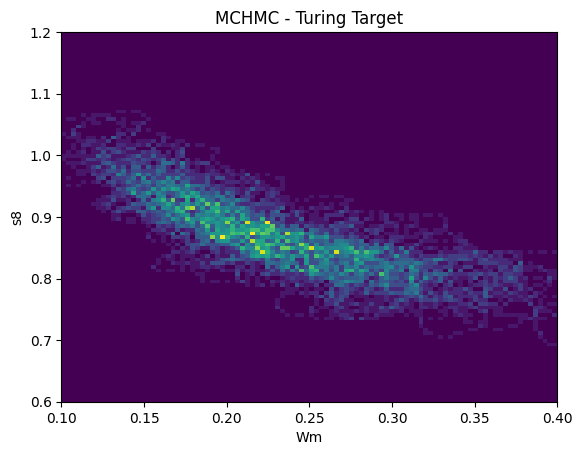

In [23]:
plt.hist2d(Wms_mchmc, s8s_mchmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("MCHMC - RSD model");

## NUTS

In [13]:
@time samples_hmc = sample(stat_model, NUTS(500, 0.65),
                  10000, progress=true; save_state=true)

┌ Info: Found initial step size
└   ϵ = 0.05
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
Sampling:   1%|▋                                        |  ETA: 0:00:13┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC ~/.julia/packages/AdvancedHMC/4fByY/src/hamiltonian.jl:49
┌ Warning: The current proposal will be reje

 18.763651 seconds (59.67 M allocations: 9.741 GiB, 11.87% gc time)


Chains MCMC chain (10000×14×1 Array{Float64, 3}):

Iterations        = 501:1:10500
Number of chains  = 1
Samples per chain = 10000
Wall duration     = 8.08 seconds
Compute duration  = 8.08 seconds
parameters        = Ωm, σ8
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

          Ωm    0.2326    0.0605     0.0006    0.0010   3044.9256    0.9999    ⋯
          σ8    0.8683    0.0601     0.0006    0.0010   2966.6408    0.9999    ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

      

In [14]:
Wms_hmc = vec(samples_hmc["Ωm"])
s8s_hmc = vec(samples_hmc["σ8"]);

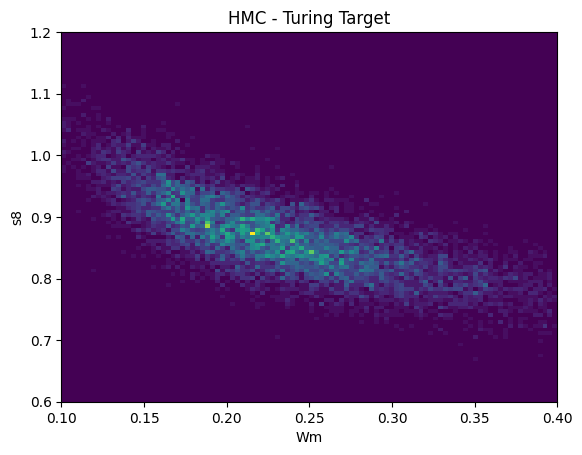

In [24]:
plt.hist2d(Wms_hmc, s8s_hmc, bins=100, range=[[0.1, 0.4],[0.6, 1.2]]);
plt.xlabel("Wm")
plt.ylabel("s8")
plt.title("HMC - RSD model");

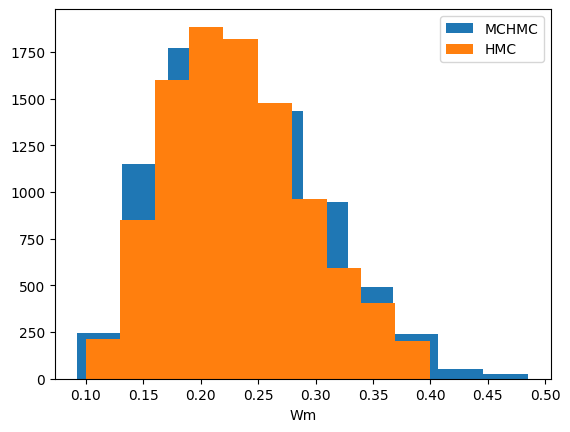

PyObject <matplotlib.legend.Legend object at 0x7f25456bcaf0>

In [26]:
plt.hist(Wms_mchmc, label="MCHMC")
plt.hist(Wms_hmc, label="HMC")
plt.xlabel("Wm")
plt.legend()

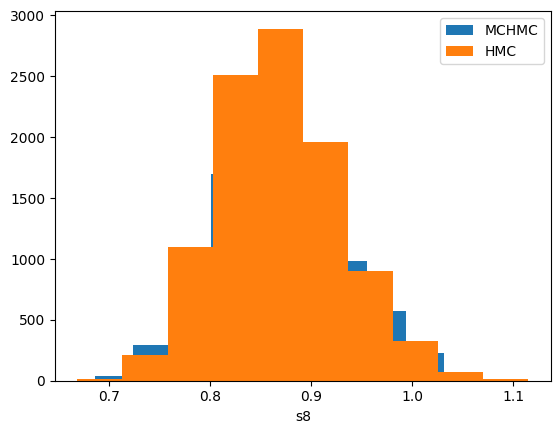

PyObject <matplotlib.legend.Legend object at 0x7f2545599610>

In [27]:
plt.hist(s8s_mchmc, label="MCHMC")
plt.hist(s8s_hmc, label="HMC")
plt.xlabel("s8")
plt.legend()

In [18]:
using AverageShiftedHistograms, Plots

LoadError: InitError: could not load library "/home/jaimerz/.julia/artifacts/1cfe0ebb804cb8b0d7d1e8f98e5cda94b2b31b3d/lib/libgobject-2.0.so"
/home/jaimerz/.julia/artifacts/1cfe0ebb804cb8b0d7d1e8f98e5cda94b2b31b3d/lib/libgobject-2.0.so: undefined symbol: g_uri_ref
during initialization of module Glib_jll

In [19]:
Wm_hmc_ker = ash(Wms_hmc; m=30)
s8_hmc_ker = ash(s8s_hmc; m=30)
Wm_mchmc_ker = ash(Wms_mchmc; m=30)
s8_mchmc_ker = ash(s8s_mchmc; m=30);

In [20]:
Plots.plot(Wm_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(Wm_hmc_ker; hist=false, label="HMC", xlabel="Wm")

LoadError: UndefVarError: `Plots` not defined

In [21]:
Plots.plot(s8_mchmc_ker; hist=false, label="MCHMC")
Plots.plot!(s8_hmc_ker; hist=false, label="HMC",  xlabel="s8")

LoadError: UndefVarError: `Plots` not defined

## Self-tuning

In [12]:
mchmc = Sampler()
println(string("L = ", mchmc.settings.L, ", eps = ", mchmc.settings.eps))
# This should start self-tuning    

L = 0.0, eps = 0.0


In [13]:
mchmc.settings.tune_samples

1000

In [14]:
samples = Sample(mchmc, target; num_steps=10000, dialog=true);

Self-tuning hyperparameters
Hyperparameter tuning (first stage)


LoadError: UndefVarError: `samples` not defined